# ДЗ #7. Градиентный бустинг <a id="0"></a>

### Датасет: https://archive.ics.uci.edu/ml/datasets/Census+Income

* [Загрузка данных и базовые статистики](#1)
* [EDA](#2)
* [ML](#3)
    * Baseline
    * sklearn.AdaBoost
    * sklearn.GradientBoosting
    * XGBClassifier
    * CatBoostClassifier
    * LGBMClassifier
* [ML. Подбор оптимальных гиперпараметров](#4)    
    * XGBoost
    * CatBoost
    * LightGBM
* [Результат](#5)

In [1]:
# Импорт основных библиотек
import os
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from math import sqrt
%matplotlib inline
warnings.filterwarnings("ignore")
np.random.seed(42)

---
<a id="1"></a>
## Загрузка данных и базовые статистики [(Наверх)](#0) 

In [2]:
url = ['https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
       'https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test']
filename = './data/income.csv'
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

if not os.path.exists(filename):
    income_df = pd.concat([pd.read_csv(url[0], names=column_names, skipinitialspace=True, na_values='?'), 
                           pd.read_csv(url[1], names=column_names, skipinitialspace=True, skiprows=1, na_values='?')],
                          sort=False, ignore_index=True)
    income_df.to_csv(filename, index=False)
else:
    income_df = pd.read_csv(filename)

# Проверим корректно ли загружен CSV
income_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K.
48838,64,NaN,321403,HS-grad,9,Widowed,NaN,Other-relative,Black,Male,0,0,40,United-States,<=50K.
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K.
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K.


In [3]:
# Узнаем размер датасета
income_df.shape

(48842, 15)

In [4]:
# Узнаем свойства датасета
income_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  47985 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


In [5]:
# Проверим на дубликаты и удалим если есть
income_df.drop_duplicates(inplace=True)
income_df.duplicated().sum()

0

In [6]:
# Проверим на наличие пустых данных
income_df.isnull().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     856
income               0
dtype: int64

---
<a id="2"></a>
## EDA [(Наверх)](#0) 

In [7]:
# Удалим NaN
income_df.dropna(inplace=True)

### Income

In [8]:
income_df['income'].value_counts()

<=50K     22633
<=50K.    11355
>50K       7506
>50K.      3700
Name: income, dtype: int64

In [9]:
# Сконвертируем целевую переменную 'income' в бинарный вид 
# (учтём, что некоторые значения имеют знак точки в конце)

income_bool = {'<=50K':0, '<=50K.':0, '>50K':1, '>50K.':1}
income_df['income'] = income_df['income'].map(income_bool)

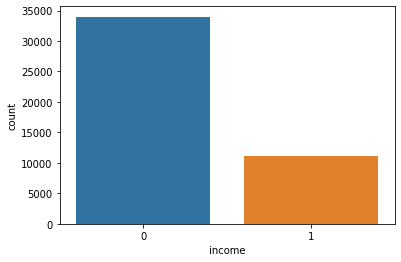

In [10]:
# Баланс целевой переменной
sns.countplot(x='income',data=income_df);

### Education & Education-num

In [11]:
# Проверим предположение, что 'education-num' расположен в порядке возрастания уровня образования
income_df[['education', 'education-num']].groupby(['education']).median().sort_values(by='education-num')

,education-num
education,
Preschool,1
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
10th,6
11th,7
12th,8
HS-grad,9


In [12]:
# Предположение оказалось верным, поэтому смело можем удалить 'education' из нашего датасета
income_df.drop(['education'], axis=1, inplace=True)

### Dummies

In [13]:
# Закодируем следующие переменные в новый df
to_dummies = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
income_1hot_df = pd.get_dummies(income_df, columns=to_dummies)

---
## Процедурная [(Наверх)](#0) 

In [14]:
# Процедура оценки качества
def quality_report(prediction, actual, label='', report_df=None):
    metrics_list = [accuracy_score(actual, prediction), 
                    precision_score(actual, prediction, average='weighted'), 
                    recall_score(actual, prediction, average='weighted'), 
                    f1_score(actual, prediction, average='weighted')]
    
    if report_df is None:
        report_df = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1']).astype('float32')
    
    report_df.loc[label, :] =  metrics_list
    
    return report_df.round(3)

In [15]:
# Процедура подготовки сетов
def split_proc(split_df, target, test_size=0.3):
    X_train, X_test, y_train, y_test = train_test_split(
        split_df.drop(labels=[target], axis=1),
        split_df[target],
        test_size=test_size,
        stratify=split_df[target],
        random_state=42)
    
    return X_train, X_test, y_train, y_test

---
<a id="3"></a>
## ML [(Наверх)](#0) 

In [16]:
# Импортируем библиотеки для ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb
import catboost
import lightgbm


In [17]:
# Получим test-train сеты
X_train, X_test, y_train, y_test = split_proc(split_df=income_1hot_df, target='income')

In [18]:
# Cтандартизируем переменные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Baseline

In [19]:
# Логистическая регрессия
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train_scaled, y_train)
report = quality_report(log_reg.predict(X_test_scaled), y_test.values, label='log-reg (default)')

In [20]:
# K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=24)
knn.fit(X_train_scaled, y_train)
report = quality_report(knn.predict(X_test_scaled), y_test.values, label='knn (neigh=24)', report_df=report)

In [21]:
# Support vectors machine
svc = svm.SVC(random_state=42)
svc.fit(X_train_scaled, y_train)
report = quality_report(svc.predict(X_test_scaled), y_test.values, label='svm (linear)', report_df=report)

In [22]:
# Decision Tree
dtc = DecisionTreeClassifier(max_depth=5, random_state=42)
dtc.fit(X_train, y_train)
report = quality_report(dtc.predict(X_test), y_test.values, label='tree (depth=5)', report_df=report)

In [23]:
# Random Forest
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)
rfc.fit(X_train_scaled, y_train)
report = quality_report(rfc.predict(X_test_scaled), y_test.values, label='forest', report_df=report)

### sklearn.AdaBoost

In [24]:
abc = AdaBoostClassifier(n_estimators=300, learning_rate=1).fit(X_train, y_train)
report = quality_report(abc.predict(X_test), y_test.values, label='adaBoost (default)', report_df=report)

In [25]:
abc = AdaBoostClassifier(n_estimators=300, base_estimator=log_reg, learning_rate=1).fit(X_train_scaled, y_train)
report = quality_report(abc.predict(X_test_scaled), y_test.values, label='adaBoost (log-reg)', report_df=report)

### sklearn.GradientBoosting

In [26]:
gbc = GradientBoostingClassifier(n_estimators=300, max_depth=3).fit(X_train, y_train)
report = quality_report(gbc.predict(X_test), y_test.values, label='gradientBoost', report_df=report)

### XGBClassifier

In [27]:
xgbc = xgb.XGBClassifier(max_depth=5, n_estimators=300, n_jobs=-1, min_child_weight=3).fit(X_train, y_train)
report = quality_report(xgbc.predict(X_test), y_test.values, label='xgBoost (cls)', report_df=report)

### CatBoostClassifier

In [28]:
cbc = catboost.CatBoostClassifier(iterations=30, learning_rate=1, depth=5, logging_level='Silent').fit(X_train, y_train)
report = quality_report(cbc.predict(X_test), y_test.values, label='catBoost (cls)', report_df=report)

### LGBMClassifier

In [29]:
lgbc = lightgbm.LGBMClassifier().fit(X_train, y_train)
report = quality_report(lgbc.predict(X_test), y_test.values, label='lightGBM (cls)', report_df=report)

---
<a id="4"></a>
## ML. Подбор оптимальных гиперпараметров [(Наверх)](#0) 

In [30]:
# Для подбора оптимальных параметров будем использовать Hyperopt (https://github.com/hyperopt/hyperopt)
from hyperopt import hp, fmin, tpe, STATUS_OK
N_ROUNDS = 200

### XGBoost

In [31]:
dm_train = xgb.DMatrix(X_train, label=y_train)
dm_test = xgb.DMatrix(X_test, label=y_test)

In [32]:
def hp_xgb_score(params):
    iterations = 150
    model = xgb.train(params, dm_train, iterations)
    preds = np.round(model.predict(dm_test)).astype(int)
    test_loss = accuracy_score(y_test.values, preds)
    
    return {'loss': test_loss, 'status': STATUS_OK, 'y': preds}

In [33]:
xgb_space = {'n_estimators' : hp.choice('n_estimators', np.arange(100, 505, 5, dtype=int)),
             'eta' : hp.quniform('eta', 0.025, 1, 0.025),
             'max_depth' : hp.choice('max_depth', np.arange(3, 7, dtype=int)),
             'min_child_weight' : hp.quniform('min_child_weight', 1, 5, 1),
             'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
             'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
             'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
             'objective': 'binary:logistic',
             'nthread' : 6, 'silent' : 1}

best = fmin(hp_xgb_score, xgb_space, algo=tpe.suggest, max_evals=N_ROUNDS)

100%|██████████████████████████████████████████████| 200/200 [14:24<00:00,  4.32s/trial, best loss: 0.8249133416918651]


In [35]:
report = quality_report(hp_xgb_score(best)['y'], y_test.values, label='XGBoost (hyp)', report_df=report)
best

{'colsample_bytree': 0.9,
 'eta': 1.0,
 'gamma': 1.0,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'n_estimators': 53,
 'subsample': 0.5}

### CatBoost

In [36]:
cp_train = catboost.Pool(X_train, y_train)
cp_test = catboost.Pool(X_test, y_test)

In [37]:
def hp_cat_score(params):
    params['logging_level']='Silent'
    model = catboost.CatBoostClassifier(**params).fit(cp_train)
    preds = np.round(model.predict(cp_test)).astype(int)
    test_loss = accuracy_score(y_test.values, preds)
    
    return {'loss': test_loss, 'status': STATUS_OK, 'y': preds}

In [38]:
cat_space = {'iterations' : 1000,
             'learning_rate' : hp.quniform('learning_rate', 0.03, 1, 0.02),
             'depth' : hp.choice('depth', np.arange(3, 7, dtype=int)),
             'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
             'early_stopping_rounds': 500,
             'random_seed': 42}

best = fmin(hp_cat_score, cat_space, algo=tpe.suggest, max_evals=N_ROUNDS);

100%|██████████████████████████████████████████████| 200/200 [53:10<00:00, 15.95s/trial, best loss: 0.8364186149421049]


In [39]:
report = quality_report(hp_cat_score(best)['y'], y_test.values, label='CatBoost (hyp)', report_df=report)
best

{'depth': 3,
 'l2_leaf_reg': 3.022624483550495,
 'learning_rate': 1.0,
 'logging_level': 'Silent'}

### LightGBM

In [47]:
lgbm_train = lightgbm.Dataset(X_train, label=y_train)
lgbm_test = lightgbm.Dataset(X_test, label=y_test)

In [48]:
def hp_lgbm_score(params):
    model = lightgbm.train(params, lgbm_train, valid_sets=lgbm_test, verbose_eval=False)
    preds = np.round(model.predict(X_test)).astype(int)
    test_loss = accuracy_score(y_test.values, preds)
    
    return {'loss': test_loss, 'status': STATUS_OK, 'y': preds}

In [49]:
lgbm_space = {'application': 'binary',
              'objective': 'binary',
              'is_unbalance': 'true',
              'boosting': 'gbdt',
              'num_leaves': hp.choice('depth', np.arange(15, 41, dtype=int)),
              'feature_fraction': hp.quniform('feature_fraction', 0.1, 1, 0.05),
              'bagging_fraction': hp.quniform('bagging_fraction', 0.1, 1, 0.05),
              'bagging_freq': hp.choice('bagging_freq', np.arange(15, 31, dtype=int)),
              'learning_rate': hp.quniform('learning_rate', 0.025, 0.5, 0.025),
              'num_boost_round': 5000,
              'early_stopping_rounds': 1000}

best = fmin(hp_lgbm_score, lgbm_space, algo=tpe.suggest, max_evals=N_ROUNDS);

100%|██████████████████████████████████████████████| 200/200 [08:26<00:00,  2.53s/trial, best loss: 0.8027140644590309]


In [50]:
report = quality_report(hp_lgbm_score(best)['y'], y_test.values, label='LightGBM (hyp)', report_df=report)
best

{'bagging_fraction': 0.1,
 'bagging_freq': 7,
 'depth': 17,
 'feature_fraction': 0.15000000000000002,
 'learning_rate': 0.47500000000000003}

---
<a id="5"></a>
## Результат [(Наверх)](#0) 

In [51]:
report

,Accuracy,Precision,Recall,F1
log-reg (default),0.847,0.841,0.847,0.842
knn (neigh=24),0.832,0.822,0.832,0.822
svm (linear),0.846,0.839,0.846,0.839
tree (depth=5),0.846,0.840,0.846,0.835
forest,0.853,0.847,0.853,0.848
adaBoost (default),0.863,0.858,0.863,0.858
adaBoost (log-reg),0.844,0.838,0.844,0.839
gradientBoost,0.869,0.865,0.869,0.865
xgBoost (cls),0.869,0.864,0.869,0.864
catBoost (cls),0.867,0.862,0.867,0.863


### Вывод #1: 
Из классификаторов в стиле "sklearn" лучший результат показал **GradientBoostingClassifier** (gradientBoost), но и 
              **XGBClassifier** (xgBoost) и **LGBMClassifier** (lightGBM) показали сравнимые результаты

### Вывод #2: 
После тюнинга параметров лидерство занял старый добрый **XGBoost**, хотя возможно я поторопился и неправильно их всех приготовил, но эксперимент есть эксперимент :)